# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Custom Modules.
from src.modules.game import Game
from src.modules.player import Player

# Custom Functions.
from src.helpers.recurse_player import recursePlayer,dealHouse,getReward
from src.helpers.q_learning import initQ,learnPolicy,evaluatePolicy,getBestAction,genEpisode
from src.helpers.plotting import dfBestMove

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [12]:
blackjack = Game()
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [48]:
for n in range(nTrials) :
    print('{} of {}'.format(n+1,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [49]:
np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [50]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [51]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,St,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [52]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,Do,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [53]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Sp,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,St,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it's equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [15]:
# Establish constants for training / evaluation / inference

###########################################################
############# object to fill during training ##############
###########################################################
Q = {
    'name':'Q Sampling',
    'evaluation':[],
    'q_max_eval': [],
}

###########################################################
################ training hyperparameters #################
###########################################################

nEpisodes = int(5e6) # number of rounds to train for.
gamma = .9 # decay hyperparameter. How much to discount sequential actions. Should be < 1.
lr = .001 # learning rate
earlyStop = False # whether we should early stop.
e = 10 # early stopping criterion. Number of "every" that have to pass without improvement.
every = 10000
nRoundsEvaluate = 1000 # number of hands to play during evaluation step
# will intermittently store best Q values through evaluation
backtrack = False # whether to revert back to optimal Q values after training completes.
method = "thompson" # sampling method during training exploration vs. exploitation

###########################################################
############### player module hyperparams #################
###########################################################

nPlayers = 1 # number of players
wagers = [1]*nPlayers # wagers per player "units"

moves = ['stay','hit','split','double','surrender'] # valid moves.


# These are all the possible rules the module allows for. There are default ones included in Game()
rules = {
    "dealerHitSoft17": True,
    "pushDealer22": False,
    "doubleAfterSplit": True,
    "hitAfterSplitAces": False,
    "reducedBlackjackPayout": False,
    "allowLateSurrender": True,
}


In [16]:
game_hyperparams = {
    "shrinkDeck": True,
    "nDecks": 6,
    "ratioPenetrate": 2/3,
    "verbose": False,
    "rules": rules
}

In [12]:
# Generate random states according to a random policy

blackjack = Game(**game_hyperparams)

r_states = []

while len(r_states) < 100 :
    blackjack.initRound(wagers)
    blackjack.dealInit()
    s_s,_ = genEpisode(blackjack,0,initQ(moves,allCards), 1, "epsilon")
    if not s_s[0]: continue
    # randomly sample a state.
    ind_rand = np.random.choice(range(len(s_s[0])))
    p,h,a,split,c1,_ = s_s[0][ind_rand]
    if split :
        r_states.append((c1,h,a,split))
    else :
        r_states.append((p,h,a,split))

### I'll learn according to standard rules of play. I can evaluate by tweaking rules to observe house edge for both.

In [14]:
blackjack = Game(**game_hyperparams)

allCards = list(blackjack.cardMap.values())
Q['Q'] = initQ(moves,allCards)

time_start = datetime.datetime.now()

r = 0
counter = 0
minPerformance = -10

if method == "epsilon" :
    assert "min_epsilon" in Q, "must include a min_epsilon value"
    assert "epsilon_decay" in Q, "must include an epsilon_decay"

while r < nEpisodes :
    
    blackjack.initRound(wagers)
    blackjack.dealInit()
    
    if not blackjack.houseBlackjack : # If house blackjack, I don't really care to learn. Nothing we can do.
        eps = -1 # This can be anything. If "thompson" method, I ignore eps value anyways, I just don't want to compute it
        if method == "epsilon" :
            eps = max(Q['min_epsilon'],np.exp(-Q['epsilon_decay']*r)) #exponential decay factor.
        learnPolicy(blackjack,Q['Q'],nPlayers,eps,gamma,lr,method)

    if not r%every :
        # Create new blackjack game for evaluation.
        blackjackEval = Game(Player,**game_hyperparams)
        # Evaluation. This represents the avg reward, per hand, for the number of rounds specified.
        p_eval = np.mean(evaluatePolicy(blackjackEval,Q['Q'],wagers,nRoundsEvaluate)[-1])
        Q['evaluation'].append(p_eval)
        
        q_max = []
        for r_s in r_states :
            p,h,a,split = r_s
            if split :
                q_max.append(max(Q['Q']['canSplit'][(p,h,a)].values()))
            else :
                q_max.append(max(Q['Q']['noSplit'][(p,h,a)].values()))
        Q['q_max_eval'].append(np.mean(q_max))
                
        if method=="epsilon" :
            print('Method {} ---- {} of {} ---- EPS : {} ---- Score : {}'.format(
                Q['name'],
                r+1,
                nEpisodes,
                eps,
                p_eval
            ))
        else :
            print('Method {} ---- {} of {} ---- Score : {} ---- Time elapsed : {}'.format(
                Q['name'],
                r+1,
                nEpisodes,
                p_eval,
                datetime.datetime.now() - time_start
            ))

        if p < minPerformance : 
            counter += 1
        else :
            counter = 0
            if backtrack :
                bestQ = Q['Q'].copy() # "backtracking". This will be used as optimal Q value dict. 
        minPerformance = max(minPerformance,p)

    if (earlyStop) & (counter == e) :

        print('Early Stopping at Round {}.'.format(r))
        break

    r += 1
if not backtrack : # without backtracking, just take final Q values.
    bestQ = Q['Q'].copy()

Method Q Sampling ---- 1 of 5000000 ---- Score : -0.4285 ---- Time elapsed : 0:00:00.180284
Method Q Sampling ---- 10001 of 5000000 ---- Score : -0.1265 ---- Time elapsed : 0:00:02.127796
Method Q Sampling ---- 20001 of 5000000 ---- Score : -0.085 ---- Time elapsed : 0:00:04.080492
Method Q Sampling ---- 30001 of 5000000 ---- Score : -0.026 ---- Time elapsed : 0:00:06.044528
Method Q Sampling ---- 40001 of 5000000 ---- Score : -0.085 ---- Time elapsed : 0:00:07.979462
Method Q Sampling ---- 50001 of 5000000 ---- Score : -0.106 ---- Time elapsed : 0:00:09.944423
Method Q Sampling ---- 60001 of 5000000 ---- Score : -0.085 ---- Time elapsed : 0:00:11.893705
Method Q Sampling ---- 70001 of 5000000 ---- Score : -0.036 ---- Time elapsed : 0:00:13.904696
Method Q Sampling ---- 80001 of 5000000 ---- Score : -0.048 ---- Time elapsed : 0:00:15.898522
Method Q Sampling ---- 90001 of 5000000 ---- Score : -0.018 ---- Time elapsed : 0:00:17.846023
Method Q Sampling ---- 100001 of 5000000 ---- Score 

Method Q Sampling ---- 860001 of 5000000 ---- Score : 0.023 ---- Time elapsed : 0:02:47.201345
Method Q Sampling ---- 870001 of 5000000 ---- Score : -0.0005 ---- Time elapsed : 0:02:49.148525
Method Q Sampling ---- 880001 of 5000000 ---- Score : 0.008 ---- Time elapsed : 0:02:51.117054
Method Q Sampling ---- 890001 of 5000000 ---- Score : 0.0365 ---- Time elapsed : 0:02:53.079536
Method Q Sampling ---- 900001 of 5000000 ---- Score : -0.0615 ---- Time elapsed : 0:02:55.027039
Method Q Sampling ---- 910001 of 5000000 ---- Score : -0.0175 ---- Time elapsed : 0:02:56.954211
Method Q Sampling ---- 920001 of 5000000 ---- Score : -0.0075 ---- Time elapsed : 0:02:58.904416
Method Q Sampling ---- 930001 of 5000000 ---- Score : 0.002 ---- Time elapsed : 0:03:00.847698
Method Q Sampling ---- 940001 of 5000000 ---- Score : 0.0175 ---- Time elapsed : 0:03:02.799585
Method Q Sampling ---- 950001 of 5000000 ---- Score : -0.0295 ---- Time elapsed : 0:03:04.736221
Method Q Sampling ---- 960001 of 50000

Method Q Sampling ---- 1710001 of 5000000 ---- Score : -0.052 ---- Time elapsed : 0:05:32.348552
Method Q Sampling ---- 1720001 of 5000000 ---- Score : -0.026 ---- Time elapsed : 0:05:34.286793
Method Q Sampling ---- 1730001 of 5000000 ---- Score : 0.011 ---- Time elapsed : 0:05:36.217762
Method Q Sampling ---- 1740001 of 5000000 ---- Score : -0.0355 ---- Time elapsed : 0:05:38.202476
Method Q Sampling ---- 1750001 of 5000000 ---- Score : -0.001 ---- Time elapsed : 0:05:40.159782
Method Q Sampling ---- 1760001 of 5000000 ---- Score : 0.0925 ---- Time elapsed : 0:05:42.102261
Method Q Sampling ---- 1770001 of 5000000 ---- Score : -0.033 ---- Time elapsed : 0:05:44.024124
Method Q Sampling ---- 1780001 of 5000000 ---- Score : -0.034 ---- Time elapsed : 0:05:45.955812
Method Q Sampling ---- 1790001 of 5000000 ---- Score : 0.0245 ---- Time elapsed : 0:05:47.900357
Method Q Sampling ---- 1800001 of 5000000 ---- Score : 0.0025 ---- Time elapsed : 0:05:49.844852
Method Q Sampling ---- 1810001

Method Q Sampling ---- 2560001 of 5000000 ---- Score : 0.0195 ---- Time elapsed : 0:08:17.276689
Method Q Sampling ---- 2570001 of 5000000 ---- Score : 0.01 ---- Time elapsed : 0:08:19.193046
Method Q Sampling ---- 2580001 of 5000000 ---- Score : 0.0315 ---- Time elapsed : 0:08:21.115219
Method Q Sampling ---- 2590001 of 5000000 ---- Score : -0.05 ---- Time elapsed : 0:08:23.048047
Method Q Sampling ---- 2600001 of 5000000 ---- Score : 0.0185 ---- Time elapsed : 0:08:24.982736
Method Q Sampling ---- 2610001 of 5000000 ---- Score : 0.047 ---- Time elapsed : 0:08:26.928217
Method Q Sampling ---- 2620001 of 5000000 ---- Score : 0.086 ---- Time elapsed : 0:08:28.866655
Method Q Sampling ---- 2630001 of 5000000 ---- Score : 0.006 ---- Time elapsed : 0:08:30.814163
Method Q Sampling ---- 2640001 of 5000000 ---- Score : 0.0315 ---- Time elapsed : 0:08:32.741713
Method Q Sampling ---- 2650001 of 5000000 ---- Score : -0.0335 ---- Time elapsed : 0:08:34.674431
Method Q Sampling ---- 2660001 of 5

Method Q Sampling ---- 3410001 of 5000000 ---- Score : 0.001 ---- Time elapsed : 0:11:01.313175
Method Q Sampling ---- 3420001 of 5000000 ---- Score : -0.045 ---- Time elapsed : 0:11:03.229934
Method Q Sampling ---- 3430001 of 5000000 ---- Score : -0.005 ---- Time elapsed : 0:11:05.147600
Method Q Sampling ---- 3440001 of 5000000 ---- Score : -0.053 ---- Time elapsed : 0:11:07.048358
Method Q Sampling ---- 3450001 of 5000000 ---- Score : -0.012 ---- Time elapsed : 0:11:08.959693
Method Q Sampling ---- 3460001 of 5000000 ---- Score : -0.033 ---- Time elapsed : 0:11:10.876644
Method Q Sampling ---- 3470001 of 5000000 ---- Score : 0.025 ---- Time elapsed : 0:11:12.790555
Method Q Sampling ---- 3480001 of 5000000 ---- Score : 0.037 ---- Time elapsed : 0:11:14.708119
Method Q Sampling ---- 3490001 of 5000000 ---- Score : 0.051 ---- Time elapsed : 0:11:16.618175
Method Q Sampling ---- 3500001 of 5000000 ---- Score : -0.016 ---- Time elapsed : 0:11:18.533749
Method Q Sampling ---- 3510001 of 

Method Q Sampling ---- 4260001 of 5000000 ---- Score : -0.005 ---- Time elapsed : 0:13:45.000117
Method Q Sampling ---- 4270001 of 5000000 ---- Score : 0.0255 ---- Time elapsed : 0:13:46.949057
Method Q Sampling ---- 4280001 of 5000000 ---- Score : -0.0195 ---- Time elapsed : 0:13:48.895635
Method Q Sampling ---- 4290001 of 5000000 ---- Score : -0.0035 ---- Time elapsed : 0:13:50.848720
Method Q Sampling ---- 4300001 of 5000000 ---- Score : 0.0495 ---- Time elapsed : 0:13:52.793999
Method Q Sampling ---- 4310001 of 5000000 ---- Score : -0.024 ---- Time elapsed : 0:13:54.749143
Method Q Sampling ---- 4320001 of 5000000 ---- Score : -0.029 ---- Time elapsed : 0:13:56.696548
Method Q Sampling ---- 4330001 of 5000000 ---- Score : 0.0125 ---- Time elapsed : 0:13:58.656995
Method Q Sampling ---- 4340001 of 5000000 ---- Score : 0.0005 ---- Time elapsed : 0:14:00.601917
Method Q Sampling ---- 4350001 of 5000000 ---- Score : 0.028 ---- Time elapsed : 0:14:02.535131
Method Q Sampling ---- 436000

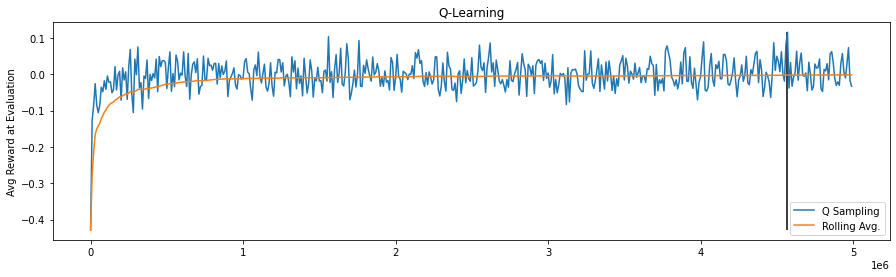

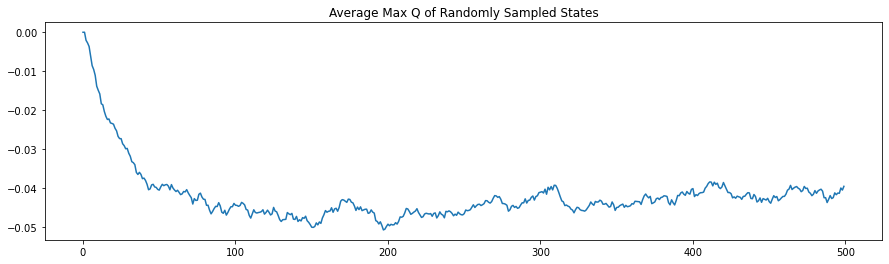

In [15]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    Q['evaluation'],
    label=Q['name']
)
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    np.cumsum(Q['evaluation']) / np.arange(1,len(Q['evaluation'])+1),
    label='Rolling Avg.'
)
plt.vlines(x=np.argmax(Q['evaluation'])*every,ymin=min(Q['evaluation']),ymax=max(Q['evaluation']),color='k')
plt.title("Q-Learning")
plt.ylabel("Avg Reward at Evaluation")
plt.legend()
plt.show()


plt.figure(figsize=(15,4))
plt.title("Average Max Q of Randomly Sampled States")
plt.plot(Q['q_max_eval'])
plt.show()

In [13]:
#np.save('./models/Q',bestQ)
Qlearned = np.load('./models/Q.npy',allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

In [17]:
# I found online that this gameplay was optimal.

# I need to favor splitting, surrendering, doubling, if they are possible actions (ie, first move of the game).
# I'll consider Stay/Hit as fallback moves, and denote them as 0.5
# Since the action space gets narrowed during training/inference, the value of 1 is ignored for double/surrender/split

acceptedQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in acceptedQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=="canSplit" :
            if p == "A" :
                p = 11
            if p <= 3 :
                vals["hit"] = 0.5
                if h <= 7 :
                    vals["split"] = 1
            if p == 4 :
                vals["hit"] = 0.5
                if h in [5,6] :
                    vals["split"] = 1
            if p == 5 :
                vals["hit"] = 0.5
                if h <= 9 :
                    vals["double"] = 1
            if p == 6 :
                if h in [4,5,6] :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                if h <= 6 :
                    vals["split"] = 1
            if p == 7 :
                if h <= 6 :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                if h <= 7 :
                    vals["split"] = 1
            if p == 8 :
                if h <= 6 :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                vals["split"] = 1
            if p == 9 :
                vals["stay"] = 0.5
                if h in [2,3,4,5,6,8,9] :
                    vals["split"] = 1
            if p == 10 :
                vals["stay"] = 0.5
            if p == 11 :
                vals["split"] = 1
        else :
            if not a :
                if p <= 8 :
                    vals["hit"] = 0.5
                if p == 9 :
                    vals["hit"] = 0.5
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                if p == 10 :
                    vals["hit"] = 0.5
                    if h <= 9 :
                        vals["double"] = 1
                if p == 11 :
                    vals["hit"] = 0.5
                    vals["double"] = 1
                if p == 12 :
                    if 4 <= h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                if p in [13,14] :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                if p == 15 :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h == 10 :
                        vals["surrender"] = 1
                if p == 16 :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h >= 9 :
                        vals["surrender"] = 1
                if p >= 17 :
                    vals["stay"] = 0.5
            else :
                if p in [13,14] :
                    vals["hit"] = 0.5
                    if h in [5,6] :
                        vals["double"] = 1
                if p in [15,16] :
                    vals["hit"] = 0.5
                    if h in [4,5,6] :
                        vals["double"] = 1
                if p == 17 :
                    vals["hit"] = 0.5
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                if p == 18 :
                    if h <= 8 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h <= 6 :
                        vals["double"] = 1
                if p == 19 :
                    vals["stay"] = 0.5
                    if h == 6 :
                        vals["double"] = 1
                if p == 20 :
                    vals["stay"] = 0.5  

Generating Random Rewards...
Generating Learned Rewards...
Generating Accepted Rewards... (found online to be optimal play)
Generating Meh Rewards...
Done


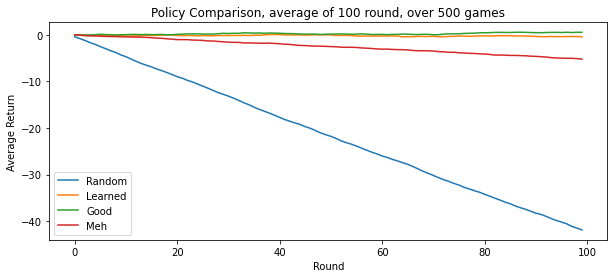

In [34]:
nRoundsEvaluate = 100 # number of rounds to play
nIterations = 500 # number of times to play above number of rounds (average is taken)

print('Generating Random Rewards...')
randQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
blackjack = Game(**game_hyperparams)
randomRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)

print('Generating Learned Rewards...')
blackjack = Game(**game_hyperparams)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
except :
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print("Generating Accepted Rewards... (found online to be optimal play)")
blackjack = Game(Player,**game_hyperparams)
acceptedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,acceptedQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print('Generating Meh Rewards...')
somewhatSmartQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in somewhatSmartQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=='canSplit' :
            if p == 'A' :
                p = 12
            else :
                p = p*2
        if p >= 17 :
            vals['stay'] = 1
        else :
            vals['hit'] = 1

blackjack = Game(Player,**game_hyperparams)
mehRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)
print('Done')

plt.figure(figsize=(10,4))
plt.title(f'Policy Comparison, average of {nRoundsEvaluate} round, over {nIterations} games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(acceptedRewards,label='Good')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

Focusing in on learned + accepted policies


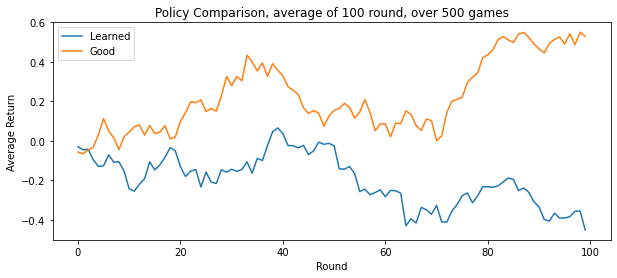

In [35]:
print("Focusing in on learned + accepted policies")
plt.figure(figsize=(10,4))
plt.title(f'Policy Comparison, average of {nRoundsEvaluate} round, over {nIterations} games')
plt.plot(learnedRewards,label='Learned')
plt.plot(acceptedRewards,label='Good')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

In [20]:
print("We can observe the Expected Value of Blackjack following these policies:")
print("This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)\n")
print("Play Randomly:")
print(f"\t{(randomRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Mimicing the House:")
print(f"\t{(mehRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Following Accepted Policy:")
print(f"\t{(acceptedRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Following Learned Policy:")
print(f"\t{(learnedRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")

We can observe the Expected Value of Blackjack following these policies:
This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)

Play Randomly:
	-0.4229 units net per round

Mimicing the House:
	-0.0548 units net per round

Following Accepted Policy:
	0.0059 units net per round

Following Learned Policy:
	-0.0003 units net per round



### While sampling helped in training Q values, it's clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn't even take card count into account**

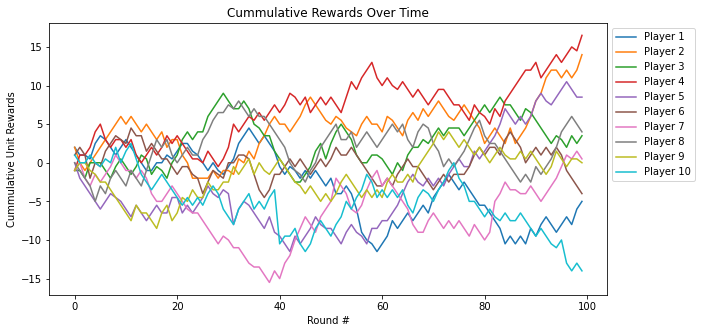

In [21]:
plt.figure(figsize=(10,5))

for i in range(10) :
    blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
    try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
        r = np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0])
    except :
        r = np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0])
    plt.plot(r,label='Player {}'.format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title('Cummulative Rewards Over Time')
plt.xlabel('Round #')
plt.ylabel('Cummulative Unit Rewards')
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [45]:
blackjack = Game(verbose=False, rules=rules)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)

print('Player Cards / Moves:')
while not player.isDone() :

    playerShow,canSplit,useableAce,card1 = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    if canSplit :
        move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1,"epsilon")
    else :
        move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,"epsilon")
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)

if move not in ['stay','surrender'] :
    print(player.cards)

blackjack.stepHouse()

print('\nHouse Cards / Moves:')
print(blackjack.house.cards)
print('\nResult:')
blackjack.getResults()

Player Cards / Moves:
[[5, 8]] stay

House Cards / Moves:
[[6, 4, 2, 'Q']]

Result:


([['win']], [1])

## Evaluation

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$ and take action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$

In reality, I'll use:

$$V_s = max(Q(s,a))$$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [699]:
Qlearned = np.load('./models/Q.npy',allow_pickle=True).item()

In [23]:
fill = np.empty((3,21+1,11+1),dtype='O')
value_det = np.zeros((3,21+1,11+1))

In [24]:
# Two ways to define value function
# 1. Deterministic. Pick best action
# 2. Random. Pick best action according to probability, which is normalized from possible q-values

for k,v in Qlearned['noSplit'].items() :
    p,h,a = k
    fill[int(a),p,h] = max(v,key=v.get)[:2].title()
    value_det[int(a),p,h] = max(v.values()) # Deterministic    
for k,v in Qlearned['canSplit'].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    fill[2,p,h] = max(v,key=v.get)[:2].title()
    value_det[2,p,h] = max(v.values()) # Deterministic    

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don't learn transition probabilities in this model-free method, so we always take the best action in our environment

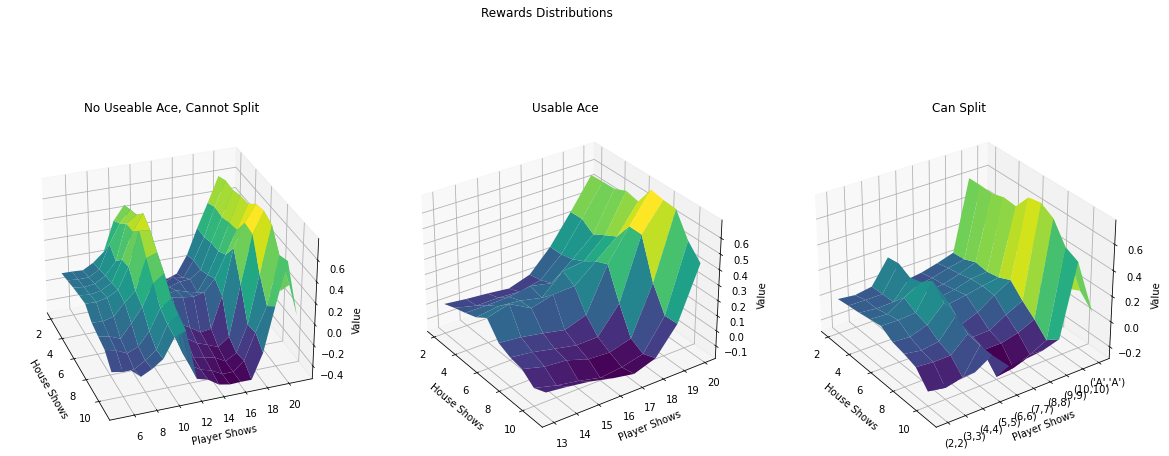

In [25]:
fig = plt.figure(figsize=(20,8))
fig.suptitle('Rewards Distributions')
ax = fig.add_subplot(131, projection='3d')
ax.set_title('No Useable Ace, Cannot Split')

noAceMesh = value_det[0][5:,2:]
x,y = np.meshgrid(range(2,12),range(5,22))
ax.plot_surface(x, y, noAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-20)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

ax = fig.add_subplot(132, projection='3d')
ax.set_title('Usable Ace')
usableAceMesh = value_det[1][13:21,2:]
x,y = np.meshgrid(range(2,12),range(13,21))

ax.plot_surface(x, y, usableAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

ax = fig.add_subplot(133, projection='3d')
ax.set_title('Can Split')

canSplitMesh = value_det[2][2:12,2:]
x,y = np.meshgrid(range(2,12),range(2,12))
ticks = ["({},{})".format(p,p) if p < 11 else "('A','A')" for p in range(2,12)]
ax.set(yticks=range(2,12), yticklabels=ticks)
ax.plot_surface(x, y, canSplitMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

plt.subplots_adjust(hspace=0, wspace=0.2)

plt.show()

In [26]:
colorMap = {'St':'blue','Hi':'green','Do':'red','Su':'grey','Sp':'yellow'}
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,Hi,Hi,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [27]:
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
usableAce

,2,3,4,5,6,7,8,9,10,11
13,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
18,Do,St,Do,Do,Do,St,St,Hi,Hi,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [28]:
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ('A','A') for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: 'background-color: %s' % colorMap[x])
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(4, 4)",Hi,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Hi,Do,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Sp
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,Sp,Sp,Sp,Sp
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


## I'm curious about frequency of busting as the house, on certain card totals

In [625]:
blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)

In [36]:
results = {}
busts = {}
player_results = {"soft":{},"hard":{}}

blackjack = Game(Player,verbose=False)

for _ in range(1000000) :

    blackjack.initRound(wagers=[1])
    blackjack.dealInit()
    player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
    houseShow = blackjack.getHouseShow(showValue=True)
    
    r_p = player._getValueCards(player.cards[0])
    soft = r_p[1]
    if r_p[0] not in player_results["soft"] :
        player_results["soft"][r_p[0]] = {"n": 0, "rewards": 0}
        player_results["hard"][r_p[0]] = {"n": 0, "rewards": 0}

    if houseShow not in results :
        results[houseShow] = {"n": 0, "bust": 0, "17": 0, "18": 0, "19": 0, "20": 0,"21": 0}
    results[houseShow]["n"] += 1


    while not player.isDone() :

        playerShow,canSplit,useableAce,card1 = player.getValue()

        policy = player.getValidMoves(houseShow)
        policy = [p for p in policy if p!='insurance']
        if canSplit :
            move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1,"epsilon")
        else :
            move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,"epsilon")

        blackjack.stepPlayer(player,move)


    blackjack.stepHouse()
    
    r = blackjack.house._getValueCards(blackjack.house.cards[0])

    if r[0] > 21 :
        results[houseShow]["bust"] += 1
        if r[0] not in busts :
            busts[r[0]] = 0
        busts[r[0]] += 1
    if r[0] <= 21 :
        results[houseShow][str(r[0])] += 1
        
    r_player = player.getResult(r[0],blackjack.house.cards)
    player_results['soft' if soft else 'hard'][r_p[0]]["n"] += 1
    player_results['soft' if soft else 'hard'][r_p[0]]["rewards"] += r_player[-1]
    
    

In [37]:
print("Average Player Rewards Given Card Total at Draw")
for i in range(4, 22) :
    print(f"Card Total: {i}")
    if player_results['soft'][i]['n'] > 0 :
        print(f"\tSoft: {player_results['soft'][i]['rewards']/player_results['soft'][i]['n']}")
    else :
        print("\tSoft: NONE")
    if player_results['hard'][i]['n'] > 0 :
        print(f"\tHard: {player_results['hard'][i]['rewards']/player_results['hard'][i]['n']}")
    else :
        print("\tHard: NONE")

Average Player Rewards Given Card Total at Draw
Card Total: 4
	Soft: NONE
	Hard: -0.22942600276625172
Card Total: 5
	Soft: NONE
	Hard: -0.2024966487935657
Card Total: 6
	Soft: NONE
	Hard: -0.2526927197879659
Card Total: 7
	Soft: NONE
	Hard: -0.20177777777777778
Card Total: 8
	Soft: NONE
	Hard: -0.13011720740614915
Card Total: 9
	Soft: NONE
	Hard: 0.0021251013617425833
Card Total: 10
	Soft: NONE
	Hard: 0.17159378388146007
Card Total: 11
	Soft: NONE
	Hard: 0.31478834755559293
Card Total: 12
	Soft: 0.3934105075690116
	Hard: -0.3116523228044879
Card Total: 13
	Soft: -0.020847400405131666
	Hard: -0.34039070304883184
Card Total: 14
	Soft: -0.03396901072705602
	Hard: -0.35985419323260814
Card Total: 15
	Soft: -0.07798010453549148
	Hard: -0.3676573426573427
Card Total: 16
	Soft: -0.11228634286681334
	Hard: -0.3604565026158618
Card Total: 17
	Soft: -0.06293351378785315
	Hard: -0.2825991672145518
Card Total: 18
	Soft: 0.025136332651670076
	Hard: -0.02479867539700459
Card Total: 19
	Soft: 0.25590

In [38]:
print("Probability of House Having a Value on Bust")
for i in range(22,27) :
    print(f"Total {i}: {100*busts[i]/sum(busts.values())}%")

Probability of House Having a Value on Bust
Total 22: 25.722327371266143%
Total 23: 23.03625430393273%
Total 24: 20.06732642841678%
Total 25: 17.229699056452233%
Total 26: 13.944392839932116%


In [46]:
print("Probability of House Result")
out = []
for i in range(2,12) :
    inter = {}
    inter["Card Show"] = i
    for j in range(17,22) :
        inter[f"% {j}"] = 100*results[i][str(j)]/results[i]['n']
    inter["% Bust"] = 100*results[i]['bust']/results[i]['n']
    out.append(inter)
              
pd.DataFrame(out)

Probability of House Result


,Card Show,% 17,% 18,% 19,% 20,% 21,% Bust
0,2,13.091131,13.380373,13.233806,12.488002,11.965291,35.841397
1,3,12.563601,13.480237,12.731910,12.232163,11.498077,37.494012
2,4,12.192616,12.682870,12.417587,11.754379,11.251122,39.701427
3,5,11.425643,12.281885,11.925118,11.316667,10.844436,42.206251
4,6,11.408125,11.383314,11.511289,11.000692,10.534495,44.162085
5,7,36.878354,13.866906,7.856744,7.876236,7.443504,26.078256
6,8,12.911438,36.314395,12.751669,6.971397,6.899956,24.151144
7,9,12.045484,11.926546,35.007189,11.931774,6.052804,23.036204
8,10,11.227729,11.104787,11.095030,33.930697,11.236836,21.404922
9,11,5.738714,14.294967,14.109722,14.373988,37.499838,13.982771


## Next, I want to incorporate "card count" into the model. This makes the space too large. The solution to this is approximating the Q learning function, through deep learning methods.